In [2]:
%load_ext autoreload

%autoreload 2

In [242]:
import os
import torch
import cv2

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.transforms import transforms


import albumentations as A
from albumentations.pytorch import ToTensorV2

In [342]:
class ConcatenatedDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, transform_positives=None, transform_background=None, target_transform=None
    ):
        self.img_labels = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        self.transform_positives = transform_positives  
        self.transform_background = transform_background 
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # image = Image.open(img_path)
        image = cv2.imread(img_path)
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[idx, 1]
        if label == 0 and self.transform_background:
            image = self.transform_background(image=image)["image"]
        if label != 0 and self.transform_positives:
            image = self.transform_positives(image=image)["image"]

        # if self.transform:
        #     image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [154]:
class CustomImageDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, transform=None, target_transform=None
    ):
        self.img_labels = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = np.array(Image.open(img_path).convert("L"))
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [129]:
dataset_positives = CustomImageDataset(annotations_file="imgs_rect/positives_labels.csv", img_dir="imgs_rect")
dataset_background = CustomImageDataset(annotations_file="imgs_raw/labels.csv", img_dir="imgs_raw") # TODO transform=random_crop equals positives
dataset = ConcatDataset([dataset_positives, dataset_background])

dataloader = DataLoader(dataset_positives, batch_size=10)

In [ ]:
img, label = dataset[0]
print(img.shape)
plt.title('{}:{}'.format(label,labels_map[label]))
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [349]:
IMAGE_HEIGHT=224
IMAGE_WIDTH=224
transform = A.Compose([
        # A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, always_apply=True),
        A.Rotate(limit=35, p=1.0),
        # A.Normalize(),
        ToTensorV2(),
    ])
whole_dataset = ConcatenatedDataset(annotations_file="imgs_merged/labels.csv", img_dir="imgs_merged", transform_background=transform, transform_positives=transform)
whole_dataloader = DataLoader(whole_dataset, batch_size=10)

In [ ]:
figure = plt.figure(figsize=(8, 8))
img,label = whole_dataset[0]
figure.add_subplot(0, 0)
plt.imshow(img, cmap="gray")

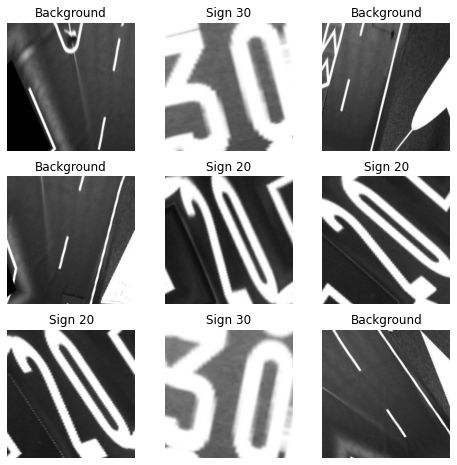

In [350]:
labels_map = {0: "Background", 1:"Sign 20", 2:"Sign 30"}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(whole_dataset), size=(1,)).item()
    img, label = whole_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()

In [301]:
df = whole_dataset.img_labels.reset_index()
splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

splits = []
for train_idx, test_idx in splitter.split(df["index"], df[1]):
    splits.append((train_idx, test_idx))